# Questions Clustering - English

## Expected
Questions to be sorted out such that the response to the whole cluster is same.

<!--### To Do-->
Author: Sunanda Bansal  
Organization: Dataperformers  
License: CC BY-NC  
Date: 24 Mar, 2020 (Start)  

In [105]:
import re
import regex
import os
import csv
import sys
import json
import time
import scipy
import socket
import pickle
import numpy as np
import pandas as pd
import multiprocessing as mp

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer   
from sklearn import metrics   
from sklearn.metrics import confusion_matrix
# from sklearn.metrics.pairwise import paired_distances as sklearn_paired_distances

# Plotting
import seaborn as sn
import matplotlib.pyplot as plt

# importing personal development helper classes
import utils

## Define variables here

Mostly the code will be intended to use with arguments that can be passed in comman line, but jupyter notebook doesn't handle `argparse` well, so the Args class is a temporary way to write the code assumming the variables to be an attribute of an object.

In [106]:
class Args:
    def __init__(self):
        # The very big scraped file, give absolute path, outside the repo
        # self.filename = "query_result_2020-03-27T19_12_30.866993Z.csv"
        self.filename = "covid_questions_2020-04-21.csv"
        
        # path to the file
        self.dataset = f"data/{self.filename}"    
        
        # suffix used to create
        self.suffix = "_".join([word for word in self.filename.split("_") if not word.isalpha()])[:-4]
        self.vector_mode = "tfidf"
        self.n_topics = 230
        self.dist_thresh = 1.5
        self.lang = "en"
args=Args()

In [107]:
# Disable (FALSE) displaying warnings from the OpenMP* run-time library during program execution.
os.environ['KMP_WARNINGS'] = "FALSE"

## Functions

In [108]:
# Regex functions
def surrounding(word,area=2):
    # A funtion, yet to be defined, that can be used to extract text around keywords
    return

def fuzzy_match(word,pattern):
    '''
        Fuzzy matching function to be used with .apply() of pandas

        Reason - Fuzzy matching is available in regex package, not in re package, 
        therefore fuzzy matching is not a part of pandas string matching functions
    '''
 
    if regex.search(pattern, word, re.IGNORECASE):
        return True
    else:
        return False    
    
# Language Detection
from langdetect import detect
def detect_lang(text):
    # Used to detect language of the question
    try:
        return detect(text)
    except:
        return "unidentifiable"   

### Natural Lanuage Proprocessing Functions
   
Preprocessing done -
   1. Normalizing accents  
   2. Removing non alphabetic characters  
   3. Casefolding  

Preprocessing not done -
   1. Stopword removal - For questions, stopwords are essential and thus are retained
   2. Stemming - For rule based analysis it might be useful to keep the words as they are, for LSA, the questions don't have enough variation in content to benefit for stemming

In [109]:
import re
import nltk
import unidecode

# Regular expression to select all that is not alphabet
# @maybe allow numbers as well
alpha_regex = re.compile('[^a-zA-Z]')

from nltk.corpus import stopwords as sw
if args.lang == "en": stopwords = sw.words('english')
if args.lang == "fr": stopwords = sw.words('french')

from nltk.stem.snowball import SnowballStemmer
if args.lang == "en": stemmer = SnowballStemmer("english")
if args.lang == "fr": stemmer = SnowballStemmer("french")

def tokenize(text):
    '''
        1. Normalized accents
        2. Splits at non alpbhaetic character (@maybe need to revisit for french text)
        3. Caasefolds
    '''    
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            # Handle french accents in text
            word = unidecode.unidecode(word)
            
            # Split at every non alphabet character occurrence
            clean_words = alpha_regex.sub(' ', word).split()
            
            # Casefold
            tokens.extend([word.lower() for word in clean_words])
    
    # Return tokens
    return tokens

def stem(word):
    return stemmer.stem(word).strip()

def preprocess(text):    
    tokenized = tokenize(text)
    # cleaned = [word for word in tokenized if word not in stopwords and word != '']
    # stemmed = [stem(word) for word in cleaned]
    return ' '.join(tokenized)

## Dataset

In [110]:
# Read dataset
dataset = pd.read_csv(args.dataset)
print(f"Dataset has {len(dataset)} documents")

# Detect Language
dataset["detected_lang"] = dataset.question.apply(detect_lang)

print(f"Dataset has {len(dataset[dataset.detected_lang=='en'])} english documents and {len(dataset[dataset.detected_lang=='fr'])} french documents")
print(f"{len(dataset)-len(dataset[dataset.detected_lang=='en'])-len(dataset[dataset.detected_lang=='fr'])} documents will not be processed because of different language")

Dataset has 5054 documents
Dataset has 2023 english documents and 2730 french documents
301 documents will not be processed because of different language


In [111]:
# Translation Questions from French to English
if "translated_question" not in dataset.columns:
    dataset["translated_question"] = np.nan

translated_df_path = f"data/{os.path.basename(args.filename)[:-4]}_fr.csv"
fr = pd.DataFrame(columns=["question","translated_question"])
if os.path.exists(translated_df_path):
    fr_csv = pd.read_csv(translated_df_path, index_col=0)
    fr = fr.combine_first(fr_csv)
    dataset.update(fr.translated_question)
    
# Any french questions that need to be translated?
fr_questions = dataset[
                        (dataset.detected_lang == "fr") & 
                        (dataset.translated_question.isnull())
                      ][["question","translated_question"]]

if len(fr_questions)>0:    
    try:
        from googletrans import Translator
        translator = Translator()
        translations = []
        for q in list(fr_questions.question):
            translations.append(translator.translate(q).text)
        print("Using google translate.")
    except:
        # HACK for when your IP has been blocked
        translations_file_path = f"data/{os.path.basename(args.filename)[:-4]}_fr_translations.txt"
        if os.path.exists(translations_file_path):   
            # Delete if already exists
            os.remove(translations_file_path)
        
        # Create file and initialize empty
        os.mknod(translations_file_path)      
        translations = []
        
        while (len(translations) != len(fr_questions)):
            print(f"Translate the output french to english using gogle translate and copy this into this file - {translations_file_path} \n{'-'*100}")
            print(*fr_questions.question.tolist(),sep="\n")
            # Translate the output french to english using gogle translate 
            # and copy this into a text file save as {filename}_fr_translated.txt in data folder
            input(f"{'-'*100}\nPress Enter to continue...")
            
            with open(translations_file_path,"r") as f:
                translations = f.read().split("\n")  
            
    fr_questions.translated_question = translations
    dataset.update(fr_questions.translated_question)
    dataset[dataset.detected_lang == "fr"][["question","translated_question"]].to_csv(translated_df_path)

Using google translate.


In [112]:
# Preprocess questions
eng = dataset[dataset.detected_lang == "en"].question.apply(preprocess).to_frame(name="text")
french = dataset[dataset.detected_lang == "fr"].translated_question.apply(preprocess).to_frame(name="text")
dataset["text"] = eng.combine_first(french).dropna()

# Drop
dataset = dataset.dropna(subset=['text'])

print(f"Dataset has {len(dataset)} english documents (translated and otherwise)")

Dataset has 4753 english documents (translated and otherwise)


In [113]:
# dataset[(dataset.language != "en") & (dataset.detected_lang == "en")]

In [114]:
# dataset[(dataset.language == "en") & (dataset.detected_lang != "en")]

### Length analysis for situations

In [115]:
dataset["len"] = dataset.text.apply(lambda x: len(x.split()))

In [116]:
# Set default value
dataset["cluster"] = "unclassified"

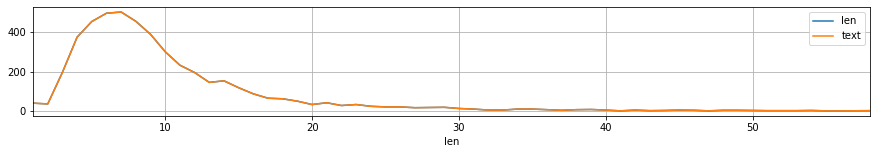

In [117]:
dataset[dataset.len<60].groupby("len")["len","text"].count().plot(figsize=(15,2),grid=True)

## Rules
Note: The order of these rules matters in resolving conflicts

In [118]:
# Separate very long questions out
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (dataset.len > 15)
                , "cluster" ] = "too-much-information"

In [119]:
# # Can be used to check if the keywords are mentioned (optional)
# dataset.loc[                     
#                     (dataset.cluster=="unclassified") & 
#                     (dataset.text.str.contains("(?:corona|covid)",case=False))
#                 , "cluster" 
#             ] = "covid-about"

In [120]:
# Statistics
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("cases",case=False)|
                        dataset.text.str.contains("dea(?:th|d)(?:ly)?",case=False)|
                        dataset.text.str.contains("died",case=False)|
                        dataset.text.str.contains("(?:mortality|death|fatality) rate",case=False)|
                        dataset.text.str.contains("statistic",case=False)|
                        (
                            dataset.text.str.contains("how",case=False)&
                            dataset.text.str.contains("many",case=False)&
                            dataset.text.str.contains("people",case=False)
                        )
                    )
                , "cluster" ] = "situation-stats"

In [121]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (dataset.text.str.contains(r"\b(?:animal|bird|cat|dog|pet)s?\b",case=False))
                , "cluster" ] = "covid-transmission-animals"

In [122]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("mask",case=False)|
                        dataset.text.str.contains("glove",case=False)
                    )
                , "cluster" ] = "covid-precaution-gear"

dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("wash",case=False)
                    )
                , "cluster" ] = "covid-precaution-disinfection"

dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains(r"\bisolat",case=False)|
                        dataset.text.str.contains(r"\bsocial dist",case=False)|
                        dataset.text.str.contains(r"\bconfine",case=False)
                    )
                , "cluster" ] = "covid-precaution-isolation"

In [123]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            (
                                dataset.text.str.contains("go (?:on|to|for|out)",case=False)|
                                dataset.text.str.contains("walk",case=False)
                            )&
                            (
                                dataset.text.str.contains("allow",case=False)|
                                dataset.text.str.contains("can",case=False)|
                                dataset.text.str.contains("ok|okay",case=False)|
                                dataset.text.str.contains("should|shall",case=False)
                            )
                        )|
                        (
                            dataset.text.str.contains("lockdown",case=False)|
                            dataset.text.str.contains(r"\bopen\b",case=False)|
                            dataset.text.str.contains(r"\bclose",case=False)
                        )
                    )
                , "cluster" ] = "situation-lockdown"

In [124]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("if i (?:have|am|m)",case=False)
                    )
                , "cluster" ] = "covid-whatif"

In [125]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains(r"i (?:have|ve)",case=False)|
                        (
                            dataset.text.str.contains(r"\b(?:has|have)",case=False)&
                            dataset.text.str.contains(r"symptom",case=False)
                        )
                        # dataset.text.str.contains(r"(?:i (?:think|feel) )?i \b(?:have|ve|am|m)\b",case=False)
                    )
                , "cluster" ] = "personal-symptoms"

In [126]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("transmi",case=False)|
                        dataset.text.str.contains("contract",case=False)|
                        dataset.text.str.contains("catch",case=False)|
                        dataset.text.str.contains("spread",case=False)|
                        dataset.text.str.contains("airborne",case=False)
                    )
                , "cluster" ] = "covid-transmission"

In [127]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("transmi",case=False)|
                        dataset.text.str.contains("contract",case=False)|
                        dataset.text.str.contains("catch",case=False)|
                        dataset.text.str.contains("spread",case=False)|
                        dataset.text.str.contains("airborne",case=False)
                    )                
                , "cluster" ] = "covid-transmission"

dataset.loc[
                    (dataset.cluster=="covid-transmission") & 
                    (
                        dataset.text.str.contains("again",case=False)|
                        dataset.text.str.contains("twice",case=False)
                    )                
                , "cluster" ] = "covid-transmission-twice"

In [128]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                            (
                                dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
                                dataset.text.str.contains("corona",case=False)|
                                dataset.text.str.contains("virus",case=False)
                            )&
                            (
                                dataset.text.str.contains("live|stay|survive",case=False)
                            )&
                            (
                                dataset.text.str.contains("on",case=False)
                            )
                    )
                , "cluster" ] = "covid-life"

In [129]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("infected",case=False)|
                        dataset.text.str.contains("infection",case=False)
                    )                
                , "cluster" ] = "covid-infection"

In [130]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                         dataset.text.str.contains("prevent",case=False)|
#                         dataset.text.str.contains("protect",case=False)|
#                         dataset.text.str.contains("precaution",case=False)|
#                         dataset.text.str.contains("safety",case=False)|
#                         (
#                             dataset.text.str.contains("keep",case=False)&
#                             dataset.text.str.contains("safe",case=False)
#                         )
#                     )               
#                 , "cluster" ] = "covid-precaution"

In [131]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                             (
#                                 dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
#                                 dataset.text.str.contains("corona",case=False)|
#                                 dataset.text.str.contains("virus",case=False)
#                             )&
#                             (
#                                 dataset.text.str.contains("kills",case=False)
#                             )
#                     )                
#               , "cluster" ] = "covid-kill"

In [132]:
# dataset.loc[
#                     (dataset.cluster=="unclassified") & 
#                     (
#                             (
#                                 (
#                                     dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
#                                     dataset.text.str.contains("corona",case=False)|
#                                     dataset.text.str.contains("virus",case=False)
#                                 )&
#                                 (
#                                     dataset.text.str.contains("fight",case=False)
#                                 )&
#                                 (
#                                     dataset.text.str.contains("help",case=False)
#                                 )
#                             )|
#                             (
#                                 dataset.text.str.contains("mask",case=False)|
#                                 dataset.text.str.contains("glove",case=False)
#                             )
#                         )                
#                     , "cluster" ] = "covid-fight"

In [133]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("treatment",case=False)|
                        dataset.text.str.contains("cure",case=False)|
                        dataset.text.str.contains("vaccine",case=False)|
                        dataset.text.str.contains("medic",case=False)
                    )                
                , "cluster" ] = "covid-med"

In [134]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("incubate",case=False)|
                        dataset.text.str.contains("incubation",case=False)
                    )      
                , "cluster" ] = "covid-incubation"

In [135]:
# dataset.loc[                     
#                        (dataset.cluster=="unclassified") & (
# #                         dataset.text.str.contains(r"\bgo\b",case=False)&
#                         (
#                             dataset.text.str.contains("hospital",case=False)|                            
#                             dataset.text.str.contains(r"\bER\b",case=False)
#                         )
#                     )
#                , "cluster" ] = "hospital"

In [136]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("diff",case=False)|
                        dataset.text.apply(fuzzy_match, pattern="(?:distinguish){e<=3}")
                    )                
                , "cluster" ] = "covid-versus"

In [137]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("tested",case=False)|
                        dataset.text.str.contains("test",case=False)
                    )                
                , "cluster" ] = "personal-testing"

dataset.loc[
                    (dataset.cluster=="personal-testing") & 
                    (
                        dataset.text.str.contains("(?:tested|test)",case=False) &
                        dataset.text.str.contains("where",case=False)
                    )                
                , "cluster" ] = "personal-testing-location"

In [138]:
dataset.loc[
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("recover",case=False)
                    )                
                , "cluster" ] = "covid-recovery"

In [139]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        dataset.text.str.contains("dangerous",case=False)|
                        dataset.text.str.contains("risk",case=False)
                    )                
                , "cluster" ] = "covid-contagious"

In [140]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (dataset.text.str.contains(r"\bsymptom",case=False))                
                , "cluster" ] = "covid-symptoms"

In [141]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            dataset.text.apply(fuzzy_match, pattern="(?:whats|what (?:is|s))")
                        ) & 
                        (
                            dataset.text.apply(fuzzy_match, pattern="(?:covid){e<=2}")|
                            dataset.text.str.contains("corona",case=False)
                        )
                    )                
                , "cluster" ] = "covid-what"

In [142]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            (
                                dataset.text.str.contains("how",case=False) &
                                dataset.text.str.contains("long",case=False)
                            )|
                            dataset.text.str.contains("when",case=False)
                        )&
                            dataset.text.str.contains("will",case=False)&
                        (
                            dataset.text.str.contains("last|end|over|normal|done",case=False)
                        )
                    )                
                , "cluster" ] = "situation-future"

In [143]:
dataset.loc[                     
                    (dataset.cluster=="unclassified") & 
                    (
                        (
                            dataset.text.str.contains("how|when|where",case=False) 
                        )&
                            dataset.text.str.contains("did",case=False)&
                        (
                            dataset.text.str.contains("start|begin|began",case=False)
                        )
                    )                
                , "cluster" ] = "situation-past"

In [144]:
features = dataset.cluster.unique().tolist()

In [145]:
features

['unclassified',
 'covid-precaution-isolation',
 'personal-testing',
 'personal-symptoms',
 'covid-transmission-animals',
 'covid-contagious',
 'too-much-information',
 'covid-symptoms',
 'situation-lockdown',
 'covid-versus',
 'covid-whatif',
 'covid-what',
 'covid-life',
 'situation-future',
 'situation-stats',
 'covid-transmission',
 'personal-testing-location',
 'covid-med',
 'covid-precaution-gear',
 'covid-precaution-disinfection',
 'covid-infection',
 'covid-recovery',
 'covid-incubation',
 'situation-past',
 'covid-transmission-twice']

In [146]:
# Clustering stats
dataset.groupby("cluster")["question"].count()

cluster
covid-contagious                  143
covid-incubation                   28
covid-infection                    97
covid-life                        117
covid-med                         106
covid-precaution-disinfection      47
covid-precaution-gear              70
covid-precaution-isolation         89
covid-recovery                     21
covid-symptoms                    453
covid-transmission                170
covid-transmission-animals         59
covid-transmission-twice           14
covid-versus                       43
covid-what                        147
covid-whatif                      168
personal-symptoms                 247
personal-testing                  159
personal-testing-location          43
situation-future                   39
situation-lockdown                163
situation-past                      4
situation-stats                   171
too-much-information              673
unclassified                     1482
Name: question, dtype: int64

In [147]:
# Saving the files
path = f"output/simpleFiltered_{args.suffix}_{args.lang}.csv"
dataset.to_csv(path)
print(f"Rules based output saved to {path}")

Rules based output saved to output/simpleFiltered_2020-04-21_en.csv


## Linguistic Analysis

In [150]:
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp_en = spacy.load("en_core_web_sm")
nlp_fr = spacy.load("fr_core_news_md")

In [159]:
dataset["spacy_doc"][~dataset.question.isna()] = dataset[dataset.detected_lang=="en"].question.apply(nlp_en)
dataset["spacy_doc"][~dataset.translated_question.isna()] = dataset[dataset.detected_lang=="en"].translated_question.dropna().apply(nlp_en)

/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
dataset[dataset.cluster == "covid-symptoms"]["spacy_doc"]

In [161]:
def analyse_dep(doc):
    if type(doc) == str:
        doc = nlp_en(doc)
    for token in doc:
        if "symptom" in token.text.lower() and "nsubj" not in token.dep_:
            print (doc)
            print ("-------------------------------------------")      
            displacy.render(doc, style='dep')
            for token in doc:
                print (token.text, token.lemma, token.tag_, token.head.text, token.dep_)  
            print ("-------------------------------------------")
            break  

In [182]:
docs = [
            "I have cough, do I have covid?", 
            "How do I know if I have covid?", 
            "My son has fever, does he have corona?", 
            "If I have pneumonia, do I have corona",
            "What are the symptoms",
            "What are symptoms of corona?",
            "What is covid-19?",
            "What's covid-19?",
            "What's corona virus?"
        ]
for doc in docs:
    if type(doc) == str:
        doc = nlp_en(doc)
        print (doc)
        print ("-------------------------------------------")      
        displacy.render(doc, style='dep')
        for token in doc:
            print ( token.head.text, token.head.lemma_, token.head.tag_, token.head.i, token.dep_, token.i, token.text, token.lemma_, token.tag_, sep="\t")  
        print ("-------------------------------------------")


I have cough, do I have covid?
-------------------------------------------


have	have	VBP	1	nsubj	0	I	-PRON-	PRP
have	have	VB	6	ccomp	1	have	have	VBP
have	have	VBP	1	dobj	2	cough	cough	NN
have	have	VB	6	punct	3	,	,	,
have	have	VB	6	aux	4	do	do	VBP
have	have	VB	6	nsubj	5	I	-PRON-	PRP
have	have	VB	6	ROOT	6	have	have	VB
have	have	VB	6	dobj	7	covid	covid	VBN
have	have	VB	6	punct	8	?	?	.
-------------------------------------------
How do I know if I have covid?
-------------------------------------------


know	know	VB	3	advmod	0	How	how	WRB
know	know	VB	3	aux	1	do	do	VBP
know	know	VB	3	nsubj	2	I	-PRON-	PRP
know	know	VB	3	ROOT	3	know	know	VB
have	have	VBP	6	mark	4	if	if	IN
have	have	VBP	6	nsubj	5	I	-PRON-	PRP
know	know	VB	3	ccomp	6	have	have	VBP
have	have	VBP	6	dobj	7	covid	covid	NNS
know	know	VB	3	punct	8	?	?	.
-------------------------------------------
My son has fever, does he have corona?
-------------------------------------------


son	son	NN	1	poss	0	My	-PRON-	PRP$
has	have	VBZ	2	nsubj	1	son	son	NN
have	have	VB	7	ccomp	2	has	have	VBZ
has	have	VBZ	2	dobj	3	fever	fever	NN
have	have	VB	7	punct	4	,	,	,
have	have	VB	7	aux	5	does	do	VBZ
have	have	VB	7	nsubj	6	he	-PRON-	PRP
have	have	VB	7	ROOT	7	have	have	VB
have	have	VB	7	dobj	8	corona	corona	NN
have	have	VB	7	punct	9	?	?	.
-------------------------------------------
If I have pneumonia, do I have corona
-------------------------------------------


have	have	VBP	2	mark	0	If	if	IN
have	have	VBP	2	nsubj	1	I	-PRON-	PRP
have	have	VB	7	advcl	2	have	have	VBP
have	have	VBP	2	dobj	3	pneumonia	pneumonia	NNS
have	have	VB	7	punct	4	,	,	,
have	have	VB	7	aux	5	do	do	VBP
have	have	VB	7	nsubj	6	I	-PRON-	PRP
have	have	VB	7	ROOT	7	have	have	VB
have	have	VB	7	dobj	8	corona	corona	NN
-------------------------------------------
What are the symptoms
-------------------------------------------


are	be	VBP	1	attr	0	What	what	WP
are	be	VBP	1	ROOT	1	are	be	VBP
symptoms	symptom	NNS	3	det	2	the	the	DT
are	be	VBP	1	nsubj	3	symptoms	symptom	NNS
-------------------------------------------
What are symptoms of corona?
-------------------------------------------


are	be	VBP	1	nsubj	0	What	what	WP
are	be	VBP	1	ROOT	1	are	be	VBP
are	be	VBP	1	attr	2	symptoms	symptom	NNS
symptoms	symptom	NNS	2	prep	3	of	of	IN
of	of	IN	3	pobj	4	corona	corona	NN
are	be	VBP	1	punct	5	?	?	.
-------------------------------------------
What is covid-19?
-------------------------------------------


is	be	VBZ	1	attr	0	What	what	WP
is	be	VBZ	1	ROOT	1	is	be	VBZ
is	be	VBZ	1	nsubj	2	covid-19	covid-19	NNS
is	be	VBZ	1	punct	3	?	?	.
-------------------------------------------
What's covid-19?
-------------------------------------------


's	be	VBZ	1	attr	0	What	what	WP
's	be	VBZ	1	ROOT	1	's	be	VBZ
's	be	VBZ	1	dep	2	covid-19	covid-19	NNS
covid-19	covid-19	NNS	2	punct	3	?	?	.
-------------------------------------------
What's corona virus?
-------------------------------------------


's	be	VBZ	1	nsubj	0	What	what	WP
's	be	VBZ	1	ROOT	1	's	be	VBZ
virus	virus	NN	3	compound	2	corona	corona	JJ
's	be	VBZ	1	nsubj	3	virus	virus	NN
's	be	VBZ	1	punct	4	?	?	.
-------------------------------------------


In [184]:
docs = ['what if i got fever', 'cough or fever', 'what should i do if a family member is quarantined', 'what if just have a mild sore throat', 'i cough but without fever what should i do', 'what is a dry cough']
docs.extend(['what precautions should you take when moving', 'how far should you keep from other people', 'should you take tylenol', 'if you get it once will you not get it once again', 'is it true that you should not take ibuprofen', 'is it true that you should not take anti inflammatory drugs when you have covid', 'from what temperature should you be alarmed', 'what precautions should you take with items from a grocery store that you take home', 'how often should you wipe down surfaces with bleach'])
for doc in docs:
    if type(doc) == str:
        doc = nlp_en(doc)
        print (doc)
        print ("-------------------------------------------")      
        displacy.render(doc, style='dep')
        for token in doc:
            print ( token.head.text, token.head.lemma_, token.head.tag_, token.head.i, token.dep_, token.i, token.text, token.lemma_, token.tag_, sep="\t")  
        print ("-------------------------------------------")


what if i got fever
-------------------------------------------


what	what	WP	0	ROOT	0	what	what	WP
got	get	VBD	3	mark	1	if	if	IN
got	get	VBD	3	nsubj	2	i	i	PRP
what	what	WP	0	advcl	3	got	get	VBD
got	get	VBD	3	dobj	4	fever	fever	NN
-------------------------------------------
cough or fever
-------------------------------------------


cough	cough	NN	0	ROOT	0	cough	cough	NN
cough	cough	NN	0	cc	1	or	or	CC
cough	cough	NN	0	conj	2	fever	fever	NN
-------------------------------------------
what should i do if a family member is quarantined
-------------------------------------------


do	do	VB	3	dobj	0	what	what	WP
do	do	VB	3	aux	1	should	should	MD
do	do	VB	3	nsubj	2	i	i	PRP
do	do	VB	3	ROOT	3	do	do	VB
quarantined	quarantine	VBN	9	mark	4	if	if	IN
member	member	NN	7	det	5	a	a	DT
member	member	NN	7	compound	6	family	family	NN
quarantined	quarantine	VBN	9	nsubjpass	7	member	member	NN
quarantined	quarantine	VBN	9	auxpass	8	is	be	VBZ
do	do	VB	3	advcl	9	quarantined	quarantine	VBN
-------------------------------------------
what if just have a mild sore throat
-------------------------------------------


have	have	VBP	3	dep	0	what	what	WP
have	have	VBP	3	mark	1	if	if	IN
have	have	VBP	3	advmod	2	just	just	RB
have	have	VBP	3	ROOT	3	have	have	VBP
throat	throat	NN	7	det	4	a	a	DT
throat	throat	NN	7	amod	5	mild	mild	JJ
throat	throat	NN	7	amod	6	sore	sore	JJ
have	have	VBP	3	dobj	7	throat	throat	NN
-------------------------------------------
i cough but without fever what should i do
-------------------------------------------


cough	cough	VBP	1	nsubj	0	i	i	PRP
cough	cough	VBP	1	ROOT	1	cough	cough	VBP
cough	cough	VBP	1	cc	2	but	but	CC
do	do	VB	8	prep	3	without	without	IN
without	without	IN	3	pobj	4	fever	fever	NN
do	do	VB	8	dobj	5	what	what	WP
do	do	VB	8	aux	6	should	should	MD
do	do	VB	8	nsubj	7	i	i	PRP
do	do	VB	8	ROOT	8	do	do	VB
-------------------------------------------
what is a dry cough
-------------------------------------------


is	be	VBZ	1	nsubj	0	what	what	WP
is	be	VBZ	1	ROOT	1	is	be	VBZ
cough	cough	NN	4	det	2	a	a	DT
cough	cough	NN	4	amod	3	dry	dry	JJ
is	be	VBZ	1	nsubj	4	cough	cough	NN
-------------------------------------------
what precautions should you take when moving
-------------------------------------------


precautions	precaution	NNS	1	det	0	what	what	WDT
take	take	VB	4	dobj	1	precautions	precaution	NNS
take	take	VB	4	aux	2	should	should	MD
take	take	VB	4	nsubj	3	you	-PRON-	PRP
take	take	VB	4	ROOT	4	take	take	VB
moving	move	VBG	6	advmod	5	when	when	WRB
take	take	VB	4	advcl	6	moving	move	VBG
-------------------------------------------
how far should you keep from other people
-------------------------------------------


far	far	RB	1	advmod	0	how	how	WRB
keep	keep	VB	4	advmod	1	far	far	RB
keep	keep	VB	4	aux	2	should	should	MD
keep	keep	VB	4	nsubj	3	you	-PRON-	PRP
keep	keep	VB	4	ROOT	4	keep	keep	VB
keep	keep	VB	4	prep	5	from	from	IN
people	people	NNS	7	amod	6	other	other	JJ
from	from	IN	5	pobj	7	people	people	NNS
-------------------------------------------
should you take tylenol
-------------------------------------------


take	take	VB	2	aux	0	should	should	MD
take	take	VB	2	nsubj	1	you	-PRON-	PRP
take	take	VB	2	ROOT	2	take	take	VB
take	take	VB	2	dobj	3	tylenol	tylenol	NN
-------------------------------------------
if you get it once will you not get it once again
-------------------------------------------


get	get	VBP	2	mark	0	if	if	IN
get	get	VBP	2	nsubj	1	you	-PRON-	PRP
get	get	VB	8	advcl	2	get	get	VBP
get	get	VBP	2	dobj	3	it	-PRON-	PRP
get	get	VBP	2	advmod	4	once	once	RB
get	get	VB	8	aux	5	will	will	MD
get	get	VB	8	nsubj	6	you	-PRON-	PRP
get	get	VB	8	neg	7	not	not	RB
get	get	VB	8	ROOT	8	get	get	VB
get	get	VB	8	dobj	9	it	-PRON-	PRP
again	again	RB	11	advmod	10	once	once	RB
get	get	VB	8	advmod	11	again	again	RB
-------------------------------------------
is it true that you should not take ibuprofen
-------------------------------------------


is	be	VBZ	0	ROOT	0	is	be	VBZ
is	be	VBZ	0	nsubj	1	it	-PRON-	PRP
is	be	VBZ	0	acomp	2	true	true	JJ
take	take	VB	7	mark	3	that	that	IN
take	take	VB	7	nsubj	4	you	-PRON-	PRP
take	take	VB	7	aux	5	should	should	MD
take	take	VB	7	neg	6	not	not	RB
is	be	VBZ	0	ccomp	7	take	take	VB
take	take	VB	7	dobj	8	ibuprofen	ibuprofen	NN
-------------------------------------------
is it true that you should not take anti inflammatory drugs when you have covid
-------------------------------------------


is	be	VBZ	0	ROOT	0	is	be	VBZ
is	be	VBZ	0	nsubj	1	it	-PRON-	PRP
is	be	VBZ	0	acomp	2	true	true	JJ
take	take	VB	7	mark	3	that	that	IN
take	take	VB	7	nsubj	4	you	-PRON-	PRP
take	take	VB	7	aux	5	should	should	MD
take	take	VB	7	neg	6	not	not	RB
is	be	VBZ	0	ccomp	7	take	take	VB
drugs	drug	NNS	10	amod	8	anti	anti	JJ
drugs	drug	NNS	10	amod	9	inflammatory	inflammatory	JJ
take	take	VB	7	dobj	10	drugs	drug	NNS
have	have	VBP	13	advmod	11	when	when	WRB
have	have	VBP	13	nsubj	12	you	-PRON-	PRP
take	take	VB	7	advcl	13	have	have	VBP
have	have	VBP	13	dobj	14	covid	covid	NNS
-------------------------------------------
from what temperature should you be alarmed
-------------------------------------------


be	be	VB	5	prep	0	from	from	IN
temperature	temperature	NN	2	det	1	what	what	WDT
from	from	IN	0	pcomp	2	temperature	temperature	NN
be	be	VB	5	aux	3	should	should	MD
be	be	VB	5	nsubj	4	you	-PRON-	PRP
be	be	VB	5	ROOT	5	be	be	VB
be	be	VB	5	acomp	6	alarmed	alarm	VBN
-------------------------------------------
what precautions should you take with items from a grocery store that you take home
-------------------------------------------


precautions	precaution	NNS	1	det	0	what	what	WDT
take	take	VB	4	dobj	1	precautions	precaution	NNS
take	take	VB	4	aux	2	should	should	MD
take	take	VB	4	nsubj	3	you	-PRON-	PRP
take	take	VB	4	ROOT	4	take	take	VB
take	take	VB	4	prep	5	with	with	IN
with	with	IN	5	pobj	6	items	item	NNS
items	item	NNS	6	prep	7	from	from	IN
store	store	NN	10	det	8	a	a	DT
store	store	NN	10	compound	9	grocery	grocery	NN
from	from	IN	7	pobj	10	store	store	NN
take	take	VBP	13	dobj	11	that	that	WDT
take	take	VBP	13	nsubj	12	you	-PRON-	PRP
store	store	NN	10	relcl	13	take	take	VBP
take	take	VBP	13	advmod	14	home	home	RB
-------------------------------------------
how often should you wipe down surfaces with bleach
-------------------------------------------


often	often	RB	1	advmod	0	how	how	WRB
wipe	wipe	VB	4	advmod	1	often	often	RB
wipe	wipe	VB	4	aux	2	should	should	MD
wipe	wipe	VB	4	nsubj	3	you	-PRON-	PRP
wipe	wipe	VB	4	ROOT	4	wipe	wipe	VB
wipe	wipe	VB	4	prt	5	down	down	RP
wipe	wipe	VB	4	dobj	6	surfaces	surface	NNS
surfaces	surface	NNS	6	prep	7	with	with	IN
with	with	IN	7	pobj	8	bleach	bleach	NN
-------------------------------------------


In [162]:
dataset[(dataset.cluster=="personal-symptoms") | (dataset.cluster=="covid-symptoms")].spacy_doc.dropna().apply(analyse_dep)

If you start showing flu symptoms should you consult a doctor or stay home?
-------------------------------------------


If IN start mark
you PRP start nsubj
start VBP consult advcl
showing VBG start xcomp
flu NN symptoms compound
symptoms NNS showing dobj
should MD consult aux
you PRP consult nsubj
consult VB consult ROOT
a DT doctor det
doctor NN consult dobj
or CC consult cc
stay VB consult conj
home RB stay advmod
? . consult punct
-------------------------------------------
I got the flu two weeks ago and are getting symptoms again
-------------------------------------------


I PRP got nsubj
got VBD got ROOT
the DT flu det
flu NN got dobj
two CD weeks nummod
weeks NNS ago npadvmod
ago RB got advmod
and CC got cc
are VBP getting aux
getting VBG got conj
symptoms NNS getting dobj
again RB getting advmod
-------------------------------------------
is migraines a symptom?
-------------------------------------------


is VBZ is ROOT
migraines NNS is acomp
a DT symptom det
symptom NN migraines dobj
? . is punct
-------------------------------------------
what are cov19 symptoms
-------------------------------------------


what WP are attr
are VBP are ROOT
cov19 CD are advmod
symptoms NNS are attr
-------------------------------------------
is vomiting one of the symptoms?
-------------------------------------------


is VBZ vomiting aux
vomiting VBG vomiting ROOT
one CD vomiting dobj
of IN one prep
the DT symptoms det
symptoms NNS of pobj
? . vomiting punct
-------------------------------------------
is fever a symptom of coronavirus? 
-------------------------------------------


is VBZ is ROOT
fever NN is attr
a DT symptom det
symptom NN is attr
of IN symptom prep
coronavirus NN of pobj
? . is punct
-------------------------------------------
I have some symptoms, what should I do?
-------------------------------------------


I PRP have nsubj
have VBP do ccomp
some DT symptoms det
symptoms NNS have dobj
, , do punct
what WP do dobj
should MD do aux
I PRP do nsubj
do VB do ROOT
? . do punct
-------------------------------------------
Is it possible to have Covid-19 if you only have one of the symptoms?
-------------------------------------------


Is VBZ Is ROOT
it PRP Is nsubj
possible JJ Is acomp
to TO have aux
have VB Is xcomp
Covid-19 NNS have dobj
if IN have mark
you PRP have nsubj
only RB have advmod
have VBP Is advcl
one CD have dobj
of IN one prep
the DT symptoms det
symptoms NNS of pobj
? . Is punct
-------------------------------------------
Is sore throats a symptom 
-------------------------------------------


Is VBZ Is ROOT
sore JJ throats amod
throats NNS Is nsubj
a DT symptom det
symptom NN throats dobj
-------------------------------------------
Does a throat feel itchy or really sore and a symptom 
-------------------------------------------


Does VBZ feel aux
a DT throat det
throat NN feel nsubj
feel VB feel ROOT
itchy JJ feel acomp
or CC itchy cc
really RB sore advmod
sore JJ itchy conj
and CC itchy cc
a DT symptom det
symptom NN itchy conj
-------------------------------------------
 When should I consult after the vomitting symptoms for a 4 y-o child? 
-------------------------------------------


  _SP When 
When WRB consult advmod
should MD consult aux
I PRP consult nsubj
consult VB consult ROOT
after IN consult prep
the DT symptoms det
vomitting VBG symptoms compound
symptoms NNS after pobj
for IN symptoms prep
a DT child det
4 CD o nummod
y NN o compound
- HYPH o punct
o NN child compound
child NN for pobj
? . consult punct
-------------------------------------------
Can I be contagious even if I don't have symptoms? 
-------------------------------------------


Can MD be aux
I PRP be nsubj
be VB be ROOT
contagious JJ be acomp
even RB have advmod
if IN have mark
I PRP have nsubj
do VBP have aux
n't RB have neg
have VB be advcl
symptoms NNS have dobj
? . be punct
-------------------------------------------
Does the amount of virus one is exposed to change the severity of the symptoms?
-------------------------------------------


Does VBZ exposed aux
the DT amount det
amount NN exposed nsubjpass
of IN amount prep
virus NN of pobj
one CD amount appos
is VBZ exposed auxpass
exposed VBN exposed ROOT
to TO change aux
change VB exposed xcomp
the DT severity det
severity NN change dobj
of IN severity prep
the DT symptoms det
symptoms NNS of pobj
? . exposed punct
-------------------------------------------
What should I do if I don't feel any symptoms?
-------------------------------------------


What WP do dobj
should MD do aux
I PRP do nsubj
do VB do ROOT
if IN feel mark
I PRP feel nsubj
do VBP feel aux
n't RB feel neg
feel VB do advcl
any DT symptoms det
symptoms NNS feel dobj
? . do punct
-------------------------------------------
Is headache a symptom of covid-19?
-------------------------------------------


Is VBZ Is ROOT
headache NN Is nsubj
a DT symptom det
symptom NN Is attr
of IN symptom prep
covid-19 NNS of pobj
? . Is punct
-------------------------------------------
Can I infect someone if I don't have symptoms?
-------------------------------------------


Can MD infect aux
I PRP infect nsubj
infect VB infect ROOT
someone NN infect dobj
if IN have mark
I PRP have nsubj
do VBP have aux
n't RB have neg
have VB infect advcl
symptoms NNS have dobj
? . infect punct
-------------------------------------------
symptoms of covid-19
-------------------------------------------


symptoms NNS symptoms ROOT
of IN symptoms prep
covid-19 NNS of pobj
-------------------------------------------
How many days does it take to see the symptoms
-------------------------------------------


How WRB many advmod
many JJ days amod
days NNS take npadvmod
does VBZ take aux
it PRP take nsubj
take VB take ROOT
to TO see aux
see VB take xcomp
the DT symptoms det
symptoms NNS see dobj
-------------------------------------------
What should I do if I start feeling sick with similar symptoms as in covid19?
-------------------------------------------


What WP do dobj
should MD do aux
I PRP do nsubj
do VB do ROOT
if IN start mark
I PRP start nsubj
start VBP do advcl
feeling VBG start xcomp
sick JJ feeling acomp
with IN sick prep
similar JJ symptoms amod
symptoms NNS with pobj
as IN symptoms prep
in IN as prep
covid19 NN in pobj
? . do punct
-------------------------------------------
Symptoms
-------------------------------------------


Symptoms NNS Symptoms ROOT
-------------------------------------------
Whatbare the symptoms
-------------------------------------------


Whatbare VB Whatbare ROOT
the DT symptoms det
symptoms NNS Whatbare dobj
-------------------------------------------
is coughing phlem a symptom?
-------------------------------------------


is VBZ coughing aux
coughing VBG coughing ROOT
phlem VB coughing dobj
a DT symptom det
symptom NN coughing dobj
? . coughing punct
-------------------------------------------
When having covid-19, What are the next possible symptoms for a 4 years old child
-------------------------------------------


When WRB having advmod
having VBG are advcl
covid-19 NNS , punct
, , are punct
What WP are attr
are VBP are ROOT
the DT symptoms det
next JJ symptoms amod
possible JJ symptoms amod
symptoms NNS are attr
for IN symptoms prep
a DT child det
4 CD years nummod
years NNS old npadvmod
old JJ child amod
child NN for pobj
-------------------------------------------
Is headache a symptom of this pandemic? 
-------------------------------------------


Is VBZ Is ROOT
headache NN Is nsubj
a DT symptom det
symptom NN Is attr
of IN symptom prep
this DT pandemic det
pandemic NN of pobj
? . Is punct
-------------------------------------------
I have fever 38°C. Is that corona virus symptoms?
-------------------------------------------


I PRP fever nsubj
have VBP fever aux
fever VBN fever ROOT
38 CD C compound
° NNP C compound
C NN fever dobj
. . fever punct
Is VBZ Is ROOT
that DT symptoms det
corona JJ virus compound
virus NN symptoms compound
symptoms NNS Is attr
? . Is punct
-------------------------------------------
What is most usual symptom of Covid-19 
-------------------------------------------


What WP is nsubj
is VBZ is ROOT
most RBS usual advmod
usual JJ symptom amod
symptom NN is attr
of IN symptom prep
Covid-19 NNS of pobj
-------------------------------------------
Can we be contagious when we don't show symptoms?
-------------------------------------------


Can MD be aux
we PRP be nsubj
be VB be ROOT
contagious JJ be acomp
when WRB show advmod
we PRP show nsubj
do VBP show aux
n't RB show neg
show VB be advcl
symptoms NNS show dobj
? . be punct
-------------------------------------------
what are covid 19 symptoms?
-------------------------------------------


what WP are nsubj
are VBP are ROOT
covid JJ are acomp
19 CD symptoms nummod
symptoms NNS are attr
? . are punct
-------------------------------------------
Is fever the main symptom for vivid-19
-------------------------------------------


Is VBZ Is ROOT
fever NN Is attr
the DT symptom det
main JJ symptom amod
symptom NN Is attr
for IN symptom prep
vivid-19 NNS for pobj
-------------------------------------------
How long does it takes to get first symptom of Covid-19 
-------------------------------------------


How WRB long advmod
long RB takes advmod
does VBZ takes aux
it PRP takes nsubj
takes VBZ takes ROOT
to TO get aux
get VB takes xcomp
first JJ symptom amod
symptom NN get dobj
of IN symptom prep
Covid-19 NNS of pobj
-------------------------------------------
Symptoms
-------------------------------------------


Symptoms NNS Symptoms ROOT
-------------------------------------------
How many days can you be contagious without showing symptoms?
-------------------------------------------


How WRB many advmod
many JJ days amod
days NNS be npadvmod
can MD be aux
you PRP be nsubj
be VB be ROOT
contagious JJ be acomp
without IN be prep
showing VBG without pcomp
symptoms NNS showing dobj
? . be punct
-------------------------------------------
covid symptoms
-------------------------------------------


covid JJ symptoms amod
symptoms NNS symptoms ROOT
-------------------------------------------
Is sore throat a symptom?
-------------------------------------------


Is VBZ Is ROOT
sore JJ throat amod
throat NN Is nsubj
a DT symptom det
symptom NN Is npadvmod
? . Is punct
-------------------------------------------
Symptoms??
-------------------------------------------


Symptoms NNS Symptoms ROOT
? . Symptoms punct
? . Symptoms punct
-------------------------------------------
can you please tell me symptoms of corona virus?
-------------------------------------------


can MD tell aux
you PRP tell nsubj
please UH tell intj
tell VB tell ROOT
me PRP tell dative
symptoms NNS tell dobj
of IN symptoms prep
corona JJ virus compound
virus NN of pobj
? . tell punct
-------------------------------------------
symptom of corona
-------------------------------------------


symptom NN symptom ROOT
of IN symptom prep
corona NN of pobj
-------------------------------------------
Symptom
-------------------------------------------


Symptom NNP Symptom ROOT
-------------------------------------------
Can I move in with family if we have all been symptom free for 14 days?
-------------------------------------------


Can MD move aux
I PRP move nsubj
move VB move ROOT
in RB move prt
with IN move prep
family NN with pobj
if IN been mark
we PRP been nsubj
have VBP been aux
all RB been dep
been VBN move advcl
symptom NN been attr
free JJ been acomp
for IN been prep
14 CD days nummod
days NNS for pobj
? . move punct
-------------------------------------------
Which are its first symptoms?
-------------------------------------------


Which WDT are nsubj
are VBP are ROOT
its PRP$ symptoms poss
first JJ symptoms amod
symptoms NNS are attr
? . are punct
-------------------------------------------
I am feeling itchy around my body. Is it a symptom of covid? 
-------------------------------------------


I PRP feeling nsubj
am VBP feeling aux
feeling VBG feeling ROOT
itchy JJ feeling acomp
around IN feeling prep
my PRP$ body poss
body NN around pobj
. . feeling punct
Is VBZ Is ROOT
it PRP Is nsubj
a DT symptom det
symptom NN Is attr
of IN symptom prep
covid NNS of pobj
? . Is punct
-------------------------------------------
Is a cough but no fever a symptom?
-------------------------------------------


Is VBZ Is ROOT
a DT cough det
cough NN Is attr
but CC cough cc
no DT fever det
fever NN cough conj
a DT symptom det
symptom NN fever dobj
? . Is punct
-------------------------------------------
Symptoms of corona
-------------------------------------------


Symptoms NNS Symptoms ROOT
of IN Symptoms prep
corona NN of pobj
-------------------------------------------
Symptom
-------------------------------------------


Symptom NNP Symptom ROOT
-------------------------------------------
Symptoms
-------------------------------------------


Symptoms NNS Symptoms ROOT
-------------------------------------------
Does my neighbour have covid-19 symptoms?
-------------------------------------------


Does VBZ have aux
my PRP$ neighbour poss
neighbour NN have nsubj
have VB have ROOT
covid-19 JJ symptoms punct
symptoms NNS have dobj
? . have punct
-------------------------------------------
Symptoms of Covid 
-------------------------------------------


Symptoms NNS Symptoms ROOT
of IN Symptoms prep
Covid NNP of pobj
-------------------------------------------
Is missing the smelling one of the symptoms?
-------------------------------------------


Is VBZ missing aux
missing VBG missing ROOT
the DT one det
smelling VBG one amod
one CD missing dobj
of IN one prep
the DT symptoms det
symptoms NNS of pobj
? . missing punct
-------------------------------------------
Can I be assymptomatic and have covid?
-------------------------------------------


Can MD be aux
I PRP be nsubj
be VB be ROOT
assymptomatic JJ be acomp
and CC be cc
have VBP be conj
covid NNS have dobj
? . be punct
-------------------------------------------
How much time it takes to show the symptoms for corona virus
-------------------------------------------


How WRB much advmod
much JJ time amod
time NN takes npadvmod
it PRP takes nsubj
takes VBZ takes ROOT
to TO show aux
show VB takes xcomp
the DT symptoms det
symptoms NNS show dobj
for IN symptoms prep
corona JJ virus compound
virus NN for pobj
-------------------------------------------
What follow up can I do when I have symptoms?
-------------------------------------------


What WP follow nsubj
follow VBP do dobj
up RP follow prt
can MD do aux
I PRP do nsubj
do VB do ROOT
when WRB have advmod
I PRP have nsubj
have VBP do advcl
symptoms NNS have dobj
? . do punct
-------------------------------------------
Symptoms of COVID-19
-------------------------------------------


Symptoms NNS Symptoms ROOT
of IN Symptoms prep
COVID-19 NNS of pobj
-------------------------------------------
Is sore throat a symptom of covid-19?
-------------------------------------------


Is VBZ Is ROOT
sore JJ throat amod
throat NN Is nsubj
a DT symptom det
symptom NN Is attr
of IN symptom prep
covid-19 NNS of pobj
? . Is punct
-------------------------------------------
Is a runny nose a COVID-19 symptom?
-------------------------------------------


Is VBZ Is ROOT
a DT nose det
runny JJ nose amod
nose NN Is attr
a DT symptom det
COVID-19 NNP symptom compound
symptom NN Is attr
? . Is punct
-------------------------------------------
Are covid symptoms linked to the strength of the immune system
-------------------------------------------


Are VBP Are ROOT
covid JJ symptoms amod
symptoms NNS Are attr
linked VBN symptoms acl
to IN linked prep
the DT strength det
strength NN to pobj
of IN strength prep
the DT system det
immune JJ system amod
system NN of pobj
-------------------------------------------
describe the symptoms of covid 19
-------------------------------------------


describe VB describe ROOT
the DT symptoms det
symptoms NNS describe dobj
of IN symptoms prep
covid JJ 19 amod
19 CD of pobj
-------------------------------------------
describe the symptoms of covid
-------------------------------------------


describe VB describe ROOT
the DT symptoms det
symptoms NNS describe dobj
of IN symptoms prep
covid NNS of pobj
-------------------------------------------
what symptoms you have
-------------------------------------------


what WP symptoms det
symptoms NNS have dobj
you PRP have nsubj
have VBP have ROOT
-------------------------------------------
Symptomms
-------------------------------------------


Symptomms NNP Symptomms ROOT
-------------------------------------------
Can I get tested if I don’t have any symptoms?
-------------------------------------------


Can MD tested aux
I PRP tested nsubjpass
get VB tested auxpass
tested VBN tested ROOT
if IN do mark
I PRP do nsubj
do VBP have aux
n’t RB do dobj
have VB tested ccomp
any DT symptoms det
symptoms NNS have dobj
? . have punct
-------------------------------------------
If I feel stressed, can I start feeling symptoms without having coronavirus?
-------------------------------------------


If IN feel mark
I PRP feel nsubj
feel VBP start advcl
stressed JJ feel xcomp
, , start punct
can MD start aux
I PRP start nsubj
start VB start ROOT
feeling VBG start xcomp
symptoms NNS feeling dobj
without IN feeling prep
having VBG without pcomp
coronavirus NN having dobj
? . start punct
-------------------------------------------
I feel like a small ball in my throat, is this a symptom?
-------------------------------------------


I PRP feel nsubj
feel VBP is ccomp
like IN feel prep
a DT ball det
small JJ ball amod
ball NN like pobj
in IN ball prep
my PRP$ throat poss
throat NN in pobj
, , is punct
is VBZ is ROOT
this DT is nsubj
a DT symptom det
symptom NN is attr
? . is punct
-------------------------------------------
My throat is hurting, is this a symptom of coronavirus?
-------------------------------------------


My PRP$ throat poss
throat NN hurting nsubj
is VBZ hurting aux
hurting VBG is ccomp
, , is punct
is VBZ is ROOT
this DT is nsubj
a DT symptom det
symptom NN is attr
of IN symptom prep
coronavirus NN of pobj
? . is punct
-------------------------------------------
Are a loss of taste and smell symptoms of COVID-19?
-------------------------------------------


Are VBP Are ROOT
a DT loss det
loss NN Are attr
of IN loss prep
taste NN of pobj
and CC taste cc
smell NN taste conj
symptoms NNS smell dobj
of IN symptoms prep
COVID-19 NNS of pobj
? . Are punct
-------------------------------------------
I feel dizzy, is this a symptom of coronavirus?
-------------------------------------------


I PRP feel nsubj
feel VBP is ccomp
dizzy JJ feel acomp
, , is punct
is VBZ is ROOT
this DT is nsubj
a DT symptom det
symptom NN is attr
of IN symptom prep
coronavirus NN of pobj
? . is punct
-------------------------------------------
What are de symptoms of coronavirus?
-------------------------------------------


What WP are attr
are VBP are ROOT
de IN are advmod
symptoms NNS are attr
of IN symptoms prep
coronavirus NN of pobj
? . are punct
-------------------------------------------
what are he covid symptoms?
-------------------------------------------


what WP are attr
are VBP are ROOT
he PRP are nsubj
covid JJ symptoms amod
symptoms NNS are attr
? . are punct
-------------------------------------------
Can I have gastro intestinal symptoms with covid-19? 
-------------------------------------------


Can MD have aux
I PRP have nsubj
have VB have ROOT
gastro NN have dobj
intestinal JJ symptoms amod
symptoms NNS have dobj
with IN symptoms prep
covid-19 NNS with pobj
? . have punct
-------------------------------------------
Are my symptoms anxiety or covid 19
-------------------------------------------


Are VBP Are ROOT
my PRP$ anxiety poss
symptoms NNS anxiety compound
anxiety NN Are nsubj
or CC anxiety cc
covid JJ Are acomp
19 CD covid nummod
-------------------------------------------
I have a sore throat, is that an early symptom
-------------------------------------------


I PRP have nsubj
have VBP is ccomp
a DT throat det
sore JJ throat amod
throat NN have dobj
, , is punct
is VBZ is ROOT
that IN is nsubj
an DT symptom det
early JJ symptom amod
symptom NN is attr
-------------------------------------------
It is possible that I have Covid-19 only if experience only a few symptoms?
-------------------------------------------


It PRP is nsubj
is VBZ is ROOT
possible JJ is acomp
that IN have mark
I PRP have nsubj
have VBP is ccomp
Covid-19 NNS have dobj
only RB experience advmod
if IN experience mark
experience NN have advcl
only RB few advmod
a DT few quantmod
few JJ symptoms nummod
symptoms NNS experience dobj
? . is punct
-------------------------------------------
Is that a symptom?
-------------------------------------------


Is VBZ Is ROOT
that DT Is nsubj
a DT symptom det
symptom NN Is attr
? . Is punct
-------------------------------------------
Is coughing with a headache a symptom?
-------------------------------------------


Is VBZ coughing aux
coughing VBG coughing ROOT
with IN coughing prep
a DT headache det
headache NN with pobj
a DT symptom det
symptom NN coughing dobj
? . coughing punct
-------------------------------------------
Are itchy eyes a symptom of Covid 19?
-------------------------------------------


Are VBP Are ROOT
itchy JJ eyes amod
eyes NNS Are nsubj
a DT symptom det
symptom NN Are attr
of IN symptom prep
Covid NNP of pobj
19 CD Covid nummod
? . Are punct
-------------------------------------------
Is a lower than usual temperature a potential symptom?
-------------------------------------------


Is VBZ Is ROOT
a DT temperature det
lower JJR temperature amod
than IN lower prep
usual JJ temperature amod
temperature NN Is attr
a DT symptom det
potential JJ symptom amod
symptom NN Is attr
? . Is punct
-------------------------------------------
Do kids show symptoms if they get covid 19?
-------------------------------------------


Do VBP show aux
kids NNS show nsubj
show VB show ROOT
symptoms NNS show dobj
if IN get mark
they PRP get nsubj
get VBP show advcl
covid JJ get acomp
19 CD get dobj
? . show punct
-------------------------------------------
How do I tell symptoms apart between a normal flu and the Covid-19 flu?
-------------------------------------------


How WRB tell advmod
do VBP tell aux
I PRP tell nsubj
tell VB tell ROOT
symptoms NNS tell dobj
apart RB tell advmod
between IN tell prep
a DT flu det
normal JJ flu amod
flu NN between pobj
and CC flu cc
the DT Covid-19 det
Covid-19 NNS flu compound
flu NN flu conj
? . tell punct
-------------------------------------------
Even though we do not have any symptoms can we still get tested? 
-------------------------------------------


Even RB have advmod
though IN have mark
we PRP have nsubj
do VBP have aux
not RB have neg
have VB tested advcl
any DT symptoms det
symptoms NNS have dobj
can MD tested aux
we PRP tested nsubjpass
still RB tested advmod
get VB tested auxpass
tested VBN tested ROOT
? . tested punct
-------------------------------------------
Day by day symptoms?
-------------------------------------------


Day NN Day ROOT
by IN Day prep
day NN symptoms compound
symptoms NNS by pobj
? . Day punct
-------------------------------------------
How long can you be asymptomatic and have covid-19?
-------------------------------------------


How WRB long advmod
long RB be advmod
can MD be aux
you PRP be nsubj
be VB be ROOT
asymptomatic JJ be acomp
and CC be cc
have VBP be conj
covid-19 NNS be dep
? . be punct
-------------------------------------------
Is migraine a symptom of covid?
-------------------------------------------


Is VBZ Is ROOT
migraine NN Is nsubj
a DT symptom det
symptom NN Is attr
of IN symptom prep
covid NNS of pobj
? . Is punct
-------------------------------------------
Is excessive fatigue a symptom of covid?
-------------------------------------------


Is VBZ Is ROOT
excessive JJ fatigue amod
fatigue NN Is nsubj
a DT symptom det
symptom NN Is attr
of IN symptom prep
covid NNS of pobj
? . Is punct
-------------------------------------------
Symptoms 
-------------------------------------------


Symptoms NNS Symptoms ROOT
-------------------------------------------
I'm sneezing, is this a symptom? 
-------------------------------------------


I PRP sneezing nsubj
'm VBP sneezing aux
sneezing VBG is ccomp
, , is punct
is VBZ is ROOT
this DT is nsubj
a DT symptom det
symptom NN is attr
? . is punct
-------------------------------------------
I have had a cough for 4 weeks now, is it a symptom of COVID-19?
-------------------------------------------


I PRP had nsubj
have VBP had aux
had VBN is ccomp
a DT cough det
cough NN had dobj
for IN cough prep
4 CD weeks nummod
weeks NNS for pobj
now RB had advmod
, , is punct
is VBZ is ROOT
it PRP is nsubj
a DT symptom det
symptom NN is attr
of IN symptom prep
COVID-19 NNP of pobj
? . is punct
-------------------------------------------
What are the symptom levels to be considered to see a doctor
-------------------------------------------


What WP are attr
are VBP considered auxpass
the DT levels det
symptom NN levels compound
levels NNS considered nsubjpass
to TO considered aux
be VB considered auxpass
considered VBN considered ROOT
to TO see aux
see VB considered xcomp
a DT doctor det
doctor NN see dobj
-------------------------------------------
I have a feelingon congestion in my chest, is this a symptom?
-------------------------------------------


I PRP have nsubj
have VBP is ccomp
a DT congestion det
feelingon NN congestion compound
congestion NN have dobj
in IN congestion prep
my PRP$ chest poss
chest NN in pobj
, , is punct
is VBZ is ROOT
this DT is nsubj
a DT symptom det
symptom NN is attr
? . is punct
-------------------------------------------
I have malaise. Can this be a symptom? 
-------------------------------------------


I PRP have nsubj
have VBP have ROOT
malaise NN have dobj
. . have punct
Can MD be aux
this DT be nsubj
be VB be ROOT
a DT symptom det
symptom NN be attr
? . be punct
-------------------------------------------
Symptoms
-------------------------------------------


Symptoms NNS Symptoms ROOT
-------------------------------------------
If no symptoms is it ok to see another with no symptoms?
-------------------------------------------


If IN is mark
no DT symptoms det
symptoms NNS is nsubj
is VBZ is ROOT
it PRP is nsubj
ok JJ is acomp
to TO see aux
see VB is advcl
another DT see dobj
with IN see prep
no DT symptoms det
symptoms NNS with pobj
? . is punct
-------------------------------------------
Covid symptoms
-------------------------------------------


Covid JJ symptoms amod
symptoms NNS symptoms ROOT
-------------------------------------------
Symptoms 
-------------------------------------------


Symptoms NNS Symptoms ROOT
-------------------------------------------
If you only have low grade fever for 3 days, is this a symptom of covid19?
-------------------------------------------


If IN have mark
you PRP have nsubj
only RB have advmod
have VBP is advcl
low JJ fever amod
grade NN fever compound
fever NN have dobj
for IN have prep
3 CD days nummod
days NNS for pobj
, , is punct
is VBZ is ROOT
this DT is nsubj
a DT symptom det
symptom NN is attr
of IN symptom prep
covid19 NN of pobj
? . is punct
-------------------------------------------


13      None
27      None
28      None
42      None
52      None
66      None
94      None
147     None
162     None
184     None
200     None
217     None
222     None
224     None
233     None
261     None
272     None
285     None
294     None
308     None
312     None
320     None
333     None
354     None
395     None
449     None
458     None
477     None
481     None
520     None
        ... 
4526    None
4552    None
4567    None
4668    None
4670    None
4676    None
4683    None
4753    None
4756    None
4782    None
4786    None
4791    None
4792    None
4796    None
4805    None
4842    None
4870    None
4874    None
4878    None
4882    None
4891    None
4951    None
4954    None
4962    None
4979    None
4999    None
5020    None
5021    None
5023    None
5029    None
Name: spacy_doc, Length: 294, dtype: object

In [ ]:
for doc in dataset[(dataset.cluster == "covid-symptoms") & (dataset.detected_lang == "en")]["spacy_doc"]:
    print (doc)
    print ("-------------------------------------------")
    for token in doc:
        print (token.text, token.tag_, token.head.text, token.dep_)          
    print ("-------------------------------------------")

In [88]:
from spacy import displacy
for cluster, doc in zip(dataset[(dataset.detected_lang == "en")]["cluster"],dataset[(dataset.detected_lang == "en")]["spacy_doc"]):
    for token in doc:
        if cluster == "covid-symptoms" and "symptom" in token.text.lower() and "nsubj" not in token.dep_:
            print (doc)
            print ("-------------------------------------------")      
#             displacy.serve(doc, style='dep')
            for token in doc:
                print (token.text, token.tag_, token.head.text, token.dep_)  
            print ("-------------------------------------------")
            break  

If you start showing flu symptoms should you consult a doctor or stay home?
-------------------------------------------
If IN start mark
you PRP start nsubj
start VBP consult advcl
showing VBG start xcomp
flu NN symptoms compound
symptoms NNS showing dobj
should MD consult aux
you PRP consult nsubj
consult VB consult ROOT
a DT doctor det
doctor NN consult dobj
or CC consult cc
stay VB consult conj
home RB stay advmod
? . consult punct
-------------------------------------------
I got the flu two weeks ago and are getting symptoms again
-------------------------------------------
I PRP got nsubj
got VBD got ROOT
the DT flu det
flu NN got dobj
two CD weeks nummod
weeks NNS ago npadvmod
ago RB got advmod
and CC got cc
are VBP getting aux
getting VBG got conj
symptoms NNS getting dobj
again RB getting advmod
-------------------------------------------
is migraines a symptom?
-------------------------------------------
is VBZ is ROOT
migraines NNS is acomp
a DT symptom det
symptom NN migrai

In [ ]:
from spacy import displacy
for doc in dataset[(dataset.cluster == "covid-symptoms") & (dataset.detected_lang == "en")]["spacy_doc"]:
    for token in doc:
        if "symptom" in token.text.lower() and "nsubj" in token.dep_:
            print (doc)
            print ("-------------------------------------------")      
            displacy.serve(doc, style='dep')
#             for token in doc:
#                 print (token.text, token.tag_, token.head.text, token.dep_)  
            print ("-------------------------------------------")
            break  

In [79]:
# for doc in dataset[dataset.cluster == "covid-symptoms"]["spacy_doc"]:
#     flag=0
#     for token in doc:
#         if (token.text.lower() in ["i","my"] or "corona" in token.text.lower()) and "subj" in token.dep_:
#             if flag==0: 
#                 print (doc)
#                 print ("-------------------------------------------")
#             print (token.text, token.tag_, token.head.text, token.dep_)            
#             flag=1
#     if flag==1:
#         print ("-------------------------------------------")
#         for token in doc:
#             print (token.text, token.tag_, token.head.text, token.dep_)
#         print ("===============================================")

In [ ]:
doc = nlp(text[0])

In [ ]:
doc

In [ ]:
for token in doc:
    print (token.text, token.tag_, token.head.text, token.dep_)

In [ ]:
from spacy import displacy
displacy.serve(doc, style='dep')

## LSA and AHC

In [69]:
'''
    If considering NLTK tokenization of questions
'''
# Combining french translations and english questions in one column
eng = dataset[dataset.detected_lang == "en"].question.to_frame(name="text")
french = dataset[dataset.detected_lang == "fr"].translated_question.to_frame(name="text")
d = eng.combine_first(french).dropna()

# Adding cluster information from rules
d["cluster"] = dataset.cluster

# Adding length as a feature
# d["len"] = dataset.len

# Selecting unclassified questions
d = d[d.cluster=="unclassified"] # May be also cluster too-much-information clusters

# Pre-processing
import nltk

stopwords_list = nltk.corpus.stopwords.words('english')
wn_lemmatizer = nltk.stem.WordNetLemmatizer()

def bulk_tokenizer(texts):
#      return [[wn_lemmatizer.lemmatize(token) for token in nltk.word_tokenize(text)] for text in texts]
     return [nltk.word_tokenize(text) for text in texts]

In [74]:
'''
    If considering the same preprocessing as used for rules above
'''
d = dataset[dataset.cluster=="unclassified"][["text","cluster","question","translated_question"]]

def bulk_tokenizer(texts):
     return [text.split() for text in texts]

In [75]:
d.head()

,text,cluster,question,translated_question
0,what is dialogue s position on sick notes,unclassified,What is Dialogue's position on sick notes?,NaN
1,what are dialogue services,unclassified,What are Dialogue services?,NaN
4,i d love to know how long i can be contagious,unclassified,I'd love to know how long I can be contagious?,NaN
11,is the cough dry or oily,unclassified,Est ce que la toux est sèche ou grasse?,Is the cough dry or oily?
12,i do n t feel well,unclassified,Je ne me sens pas bien,I don't feel well


In [76]:
args.n_topics = 15
args.dist_thresh = 0.8
model = utils.text.representation.LSI(args, tokenizer=bulk_tokenizer)
d["embedding"] = model.generate_embedding(d.text, returnarray=False)

lsa_features = pd.DataFrame(d["embedding"].values.tolist(), index= d.index).to_numpy()

use_len = False
if use_len:
    # Add len to the feature vector
    d[["embedding","len"]].apply(lambda x: x.embedding.append(x.len), axis=1)

    from sklearn import preprocessing

    x = d.embedding.tolist() #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    lsa_features = x_scaled
    
# Cluster
X = lsa_features
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
d["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(d["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
d.groupby("ahc_label")["question"].count().sort_values()

Found 74 clusters


ahc_label
61      2
60      2
55      3
41      3
68      3
64      4
11      4
57      4
40      4
56      5
71      5
30      5
51      6
32      6
25      6
66      6
42      7
29      7
27      7
26      7
44      7
58      7
4       7
17      8
20      8
23      9
33      9
45     10
65     10
70     10
     ... 
69     14
1      16
10     16
54     17
63     17
50     18
59     20
18     21
53     23
36     23
67     25
37     26
47     26
22     27
73     29
3      31
15     33
8      35
35     38
9      40
21     44
43     48
14     50
16     58
0      59
6      60
5      71
2      72
13     73
34    107
Name: question, Length: 74, dtype: int64

In [77]:
d.groupby("ahc_label")["text"].count().describe()

count     74.000000
mean      20.081081
std       20.609718
min        2.000000
25%        7.000000
50%       12.000000
75%       25.750000
max      107.000000
Name: text, dtype: float64

In [79]:
d.text[d.text.str.contains("what should i do",case=False)]

23               what should i do if i work and i am sick
326     my husband comes back from a trip and lives wi...
341                  what should i do if i start coughing
822                      my throat hurts what should i do
911                           if i cough what should i do
1240                                     what should i do
1892         last month i went on a trip what should i do
2068                what should i do if i think i am sick
2715                       i am coughing what should i do
3067    what should i do if a family member is quarant...
3170                  what should i do if i get the virus
3254    what should i do when i come back home after g...
3558                        i m coughing what should i do
3691           i cough but without fever what should i do
3913    i woke up this morning and i am having trouble...
4286                          what should i do if i cough
4764    what should i do with my children if i and my ...
Name: text, dt

In [78]:
for label in d.ahc_label.unique():
    print(f"\ncluster #{label}, count - {len(d[d.ahc_label==label])}")
    print(d[d.ahc_label==label][:10].text.tolist())


cluster #13, count - 73
['what is dialogue s position on sick notes', 'what is going to happen to us', 'what is an asymptomatic carrier', 'what is the danger for a newborn baby', 'what is pandemic', 'what s happen for country near the ecuador with a lot of hot', 'is the phlegm color suggestive of coronavirus', 'what is the contagion period', 'what is the propagation time', 'i feel constantly short of breath is this normal']

cluster #35, count - 38
['what are dialogue services', 'what are the main synptoms', 'what are the options to disinfect hand or surfaces other than soap and alcohol', 'what are the symtoms', 'what are the instructions to follow', 'what are the dangers for people over', 'i live with an elderly person what are the usual precautions for their toilet', 'what are the rates of hospitalization and the need for intensive care', 'what are the barrier gestures', 'what are effective immunity boosters']

cluster #25, count - 6
['i d love to know how long i can be contagious',

In [343]:
if "ahc_label" in dataset.columns:
    dataset = dataset.drop(columns=["ahc_label"])
dataset = dataset.join(d["ahc_label"])

In [348]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}.csv"
dataset.drop(features, axis="columns").drop(["total"], axis="columns").to_csv(path)
print(f"AHC on top of rule based output saved to {path}")

AHC on top of rule based output saved to output/simpleLsa_15n0.9dt_2020-04-21.csv


## LSA and AHC - 2nd Time

In [221]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}_{args.lang}_checked.csv"
print(path)

output/simpleLsa_15n0.9dt_2020-04-14_fr_checked.csv


In [222]:
d = pd.read_csv(path, index_col=0)

In [223]:
d = d[["question","text", "translation", "cluster", "tags", "ahc_label", "cluster_count"]]

In [224]:
d.head()

,question,text,translation,cluster,tags,ahc_label,cluster_count
247,Les animaux peuvent-ils transmettre le COVID-19?,les animaux peuvent ils transmettre le covid,Can animals transmit COVID-19?,covid-animals,covid-animals,NaN,NaN
360,"Mon chat reste libre de ces mouvements, peut-i...",mon chat reste libre de ces mouvements peut il...,"My cat remains free from these movements, can ...",covid-animals,covid-animals,NaN,NaN
611,Les animaux (sauvages ou domestiques) peuvent-...,les animaux sauvages ou domestiques peuvent il...,Can animals (wild or domestic) contract the vi...,covid-animals,covid-animals,NaN,NaN
621,Combine de temps le virus peut rester sur le p...,combine de temps le virus peut rester sur le p...,How long can the virus stay on the hair of ani...,covid-animals,"covid-animals, covid-life",NaN,NaN
714,Est-ce que mon chat ou mon chien peuvent attra...,est ce que mon chat ou mon chien peuvent attra...,Can my cat or dog catch covid-19?,covid-animals,covid-animals,NaN,NaN


In [225]:
d = create_rules_based_clusters(d, cluster_col="cluster_2")

/home/designer1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [226]:
d.head()

,question,text,translation,cluster,tags,ahc_label,cluster_count,cluster_2
247,Les animaux peuvent-ils transmettre le COVID-19?,les animaux peuvent ils transmettre le covid,Can animals transmit COVID-19?,covid-animals,covid-animals,NaN,NaN,covid-animals
360,"Mon chat reste libre de ces mouvements, peut-i...",mon chat reste libre de ces mouvements peut il...,"My cat remains free from these movements, can ...",covid-animals,"covid-animals, covid-life",NaN,NaN,unclassified
611,Les animaux (sauvages ou domestiques) peuvent-...,les animaux sauvages ou domestiques peuvent il...,Can animals (wild or domestic) contract the vi...,covid-animals,covid-animals,NaN,NaN,covid-animals
621,Combine de temps le virus peut rester sur le p...,combine de temps le virus peut rester sur le p...,How long can the virus stay on the hair of ani...,covid-animals,"covid-animals, covid-life",NaN,NaN,unclassified
714,Est-ce que mon chat ou mon chien peuvent attra...,est ce que mon chat ou mon chien peuvent attra...,Can my cat or dog catch covid-19?,covid-animals,covid-animals,NaN,NaN,covid-animals


In [333]:
# import nltk
# stopwords_list = nltk.corpus.stopwords.words('english')
# wn_lemmatizer = nltk.stem.WordNetLemmatizer()

In [334]:
def bulk_tokenizer(texts):
#      return [[wn_lemmatizer.lemmatize(token) for token in nltk.word_tokenize(text)] for text in texts]
     return [text.split() for text in texts]

In [335]:
args.n_topics = 15
args.dist_thresh = 0.8
model = utils.text.representation.LSI(args, tokenizer=bulk_tokenizer)
d["embedding"] = model.generate_embedding(d.text, returnarray=False)

# Cluster
X = pd.DataFrame(d["embedding"].values.tolist(), index= d.index).to_numpy()
clustering = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=args.dist_thresh).fit(X)
d["ahc_label"] = clustering.labels_

# Misc.
args.n_clusters = len(d["ahc_label"].unique())
print(f"Found {args.n_clusters} clusters")
d.groupby("ahc_label")["text"].count().sort_values()

Found 53 clusters


ahc_label
51     3
40     3
48     4
18     5
43     5
34     6
10     6
31     7
33     7
25     8
47     8
22     8
11     8
36     9
37     9
41    10
2     10
44    11
20    11
45    11
5     11
29    12
46    13
4     13
52    13
39    14
42    18
49    19
28    20
12    22
35    22
30    22
26    25
27    25
23    26
14    26
38    28
24    28
7     28
15    30
0     31
17    31
19    33
16    33
32    33
8     34
13    37
21    39
3     40
50    40
9     50
1     54
6     65
Name: text, dtype: int64

In [336]:
d.groupby("ahc_label")["text"].count().describe()

count    53.000000
mean     20.452830
std      14.209377
min       3.000000
25%       9.000000
50%      18.000000
75%      30.000000
max      65.000000
Name: text, dtype: float64

In [337]:
# To Translated
# print(*d.text.tolist(),sep="\n")

In [338]:
for label in d.ahc_label.unique():
    print(f"\ncluster #{label}, count - {len(d[d.ahc_label==label])}")
    print(*zip(d[d.ahc_label==label][:10].question.tolist(),d[d.ahc_label==label][:10].text.tolist()),sep="\n")


cluster #27, count - 25
('Est ce que la toux est sèche ou grasse?', 'est ce que la toux est seche ou grasse')
('Est ce que la question: arrivez vous de voyage, est ', 'est ce que la question arrivez vous de voyage est')
("Est ce que la question, arrivez vous de voyage est encore d'actualite?  Messeble que la propagation est au dela de ca? ", 'est ce que la question arrivez vous de voyage est encore d actualite messeble que la propagation est au dela de ca')
('Est-ce que la transmission communautaire est débuté?', 'est ce que la transmission communautaire est debute')
('Est ce que l’assurance maladie sera valide à l’extérieur de la province?', 'est ce que l assurance maladie sera valide a l exterieur de la province')
('Quand est-ce que ça va être terminé?', 'quand est ce que ca va etre termine')
('Est-ce que ca donne la diarrhée ?', 'est ce que ca donne la diarrhee')
('Est-ce vrai que 75% de la population sera infecté de toutes façons? ', 'est ce vrai que de la population sera infecte 

In [339]:
dataset.head()

,timestamp_est,anonymous_id,language,question,detected_lang,text,translation,statistics,caution,animals,...,guideme,test,isolation,dangerisk,transmission,symptom,about,future,total,cluster
3,2020-03-19T14:00:19.88Z,71a29314-2b32-43d5-b09a-1795a5380e60,fr,LP TEST question,fr,lp test question,LP TEST question,0,0,0,...,0,1,0,0,0,0,0,0,1,test
6,2020-03-19T13:47:48.848Z,0b0df84f-dcc5-42c0-980e-bafacd3bbdbe,fr,"Je fais une sarcoidose pulmonaire, je suis tu ...",fr,je fais une sarcoidose pulmonaire je suis tu p...,"I have pulmonary sarcoidosis, I'm more at risk...",0,0,0,...,0,0,0,1,0,0,0,0,1,dangerisk
11,2020-03-19T15:39:52.508Z,b3cd859f-a9f3-4985-a884-0a8387a9daa4,fr,Est ce que la toux est sèche ou grasse?,fr,est ce que la toux est seche ou grasse,Is the cough dry or oily?,0,0,0,...,0,0,0,0,0,0,0,0,0,unclassified
12,2020-03-19T14:16:03.429Z,34327a70-7e54-4f53-bdf6-6809c83a8d5e,fr,Je ne me sens pas bien,fr,je ne me sens pas bien,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,unclassified
17,2020-03-19T13:55:41.747Z,59eafb5a-76c4-4e07-891d-6e79276fa82d,fr,"Bonjour,",fr,bonjour,"Bonjour,",0,0,0,...,0,0,0,0,0,0,0,0,0,unclassified


In [340]:
dataset = dataset.drop(features, axis="columns").drop("total", axis="columns").join(d["ahc_label"])

In [341]:
dataset.head()

,timestamp_est,anonymous_id,language,question,detected_lang,text,translation,cluster,ahc_label
3,2020-03-19T14:00:19.88Z,71a29314-2b32-43d5-b09a-1795a5380e60,fr,LP TEST question,fr,lp test question,LP TEST question,test,NaN
6,2020-03-19T13:47:48.848Z,0b0df84f-dcc5-42c0-980e-bafacd3bbdbe,fr,"Je fais une sarcoidose pulmonaire, je suis tu ...",fr,je fais une sarcoidose pulmonaire je suis tu p...,"I have pulmonary sarcoidosis, I'm more at risk...",dangerisk,NaN
11,2020-03-19T15:39:52.508Z,b3cd859f-a9f3-4985-a884-0a8387a9daa4,fr,Est ce que la toux est sèche ou grasse?,fr,est ce que la toux est seche ou grasse,Is the cough dry or oily?,unclassified,27.0
12,2020-03-19T14:16:03.429Z,34327a70-7e54-4f53-bdf6-6809c83a8d5e,fr,Je ne me sens pas bien,fr,je ne me sens pas bien,NaN,unclassified,4.0
17,2020-03-19T13:55:41.747Z,59eafb5a-76c4-4e07-891d-6e79276fa82d,fr,"Bonjour,",fr,bonjour,"Bonjour,",unclassified,31.0


In [342]:
# print(*dataset.question.tolist(),sep="\n")

In [343]:
path = f"output/simpleLsa_{args.n_topics}n{args.dist_thresh}dt_{args.suffix}_{args.lang}.csv"
dataset.to_csv(path)
print(f"AHC on top of rule based output saved to {path}")

AHC on top of rule based output saved to output/simpleLsa_15n0.8dt_2020-03-27T19_12_30.866993Z_fr.csv


## Iterative Clustering